In [29]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("../data/prompt_engineering/gpt_files/GPT_subset_triples_prompt2_param1.csv")

# Count unique URLs
unique_url_count = df['URL'].nunique()

print(f"Number of unique URLs: {unique_url_count}")

Number of unique URLs: 44


In [9]:
import pandas as pd
import requests
from urllib.parse import urlparse
from tqdm import tqdm

# Load the Excel file
#df = pd.read_excel("../data/CBM_data/Data_CBM.xlsx")
df = pd.read_excel("../data/CBM_data/Data_CBM_with_GitHub_URLs.xlsx")

# Get unique URLs
urls = df['GitHub_Image_URL'].dropna().unique().tolist()

# Diagnostic function
def diagnose_url(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    result = {
        'URL': url,
        'Status': None,
        'Content-Type': None,
        'Redirect': None,
        'Is HTTPS': url.startswith("https://"),
        'Likely GPT-Compatible': False,
        'Error': None
    }
    
    try:
        # HEAD first (faster), fallback to GET
        r = requests.head(url, headers=headers, timeout=10, allow_redirects=True)
        if r.status_code in [405, 403, 400]:  # Some sites block HEAD
            r = requests.get(url, headers=headers, timeout=10, stream=True, allow_redirects=True)
        
        result['Status'] = r.status_code
        result['Content-Type'] = r.headers.get('Content-Type', None)
        result['Redirect'] = r.url if r.url != url else None
        
        # Basic heuristics for GPT compatibility
        if (
            r.status_code == 200 and
            result['Content-Type'] is not None and
            result['Content-Type'].startswith("image") and
            result['Is HTTPS']
        ):
            result['Likely GPT-Compatible'] = True

    except Exception as e:
        result['Error'] = str(e)

    return result

# Run diagnostics
diagnostics = [diagnose_url(url) for url in tqdm(urls)]

# Convert to DataFrame
df_diag = pd.DataFrame(diagnostics)

# Show problematic URLs
bad_urls = df_diag[~df_diag['Likely GPT-Compatible']]
print(f"\n⚠️ Found {len(bad_urls)} potentially problematic URLs out of {len(urls)}.")
bad_urls[['URL', 'Status', 'Content-Type', 'Redirect', 'Error']]

# Optionally: save to Excel
df_diag.to_excel("../data/CBM_data/CBM_URL_Diagnostics.xlsx", index=False)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


⚠️ Found 0 potentially problematic URLs out of 100.


In [3]:
import pandas as pd

# Load the diagnostics file
df_diag = pd.read_excel("../data/CBM_data/CBM_URL_Diagnostics.xlsx")

# Filter only failed cases
bad_urls = df_diag[df_diag['Likely GPT-Compatible'] == False]

# Check Content-Type and extension
def is_likely_html(row):
    content_type = str(row['Content-Type']).lower()
    url = str(row['URL']).lower()
    return (
        'html' in content_type or
        'text' in content_type or
        '?' in url or
        not url.endswith(('.jpg', '.jpeg', '.png', '.gif', '.svg'))
    )

# Flag suspicious MIME type or URL pattern
bad_urls['Looks like HTML or wrapper'] = bad_urls.apply(is_likely_html, axis=1)

# Show results
print(f"⚠️ Suspicious URLs (non-image content or dynamic endpoints):")
bad_urls[bad_urls['Looks like HTML or wrapper']][['URL', 'Content-Type', 'Redirect']]


⚠️ Suspicious URLs (non-image content or dynamic endpoints):


C:\Users\User\AppData\Local\Temp\ipykernel_3476\630145008.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_urls['Looks like HTML or wrapper'] = bad_urls.apply(is_likely_html, axis=1)


,URL,Content-Type,Redirect
0,https://www.mdpi.com/cells/cells-12-00816/arti...,text/html,NaN
2,https://www.mdpi.com/cells/cells-12-00684/arti...,text/html,NaN
10,https://www.mdpi.com/ijms/ijms-22-04081/articl...,text/html,NaN
12,https://www.mdpi.com/jcm/jcm-10-01947/article_...,text/html,NaN
19,https://www.mdpi.com/life/life-12-00285/articl...,text/html,NaN
21,https://www.mdpi.com/viruses/viruses-15-01598/...,text/html,NaN
27,https://www.mdpi.com/ijms/ijms-22-04081/articl...,text/html,NaN
31,https://www.mdpi.com/viruses/viruses-15-00400/...,text/html,NaN
39,https://www.mdpi.com/brainsci/brainsci-13-0013...,text/html,NaN
44,https://www.mdpi.com/brainsci/brainsci-10-0085...,text/html,NaN


In [7]:
import pandas as pd

# Load the file
df = pd.read_excel("../data/CBM_data/Data_CBM.xlsx")

# Add GitHub raw URL column based on Image_number
base_url = "https://raw.githubusercontent.com/Elly0w0/image-based-information-extraction-LLM-main/main/data/CBM_data/images_CBM/"

df['GitHub_Image_URL'] = df['Image_number'].apply(lambda x: f"{base_url}{x}.jpg")

# Save updated file (optional)
df.to_excel("../data/CBM_data/Data_CBM_with_GitHub_URLs.xlsx", index=False)

# Preview
df[['Image_number', 'GitHub_Image_URL']].head()

,Image_number,GitHub_Image_URL
0,image_1,https://raw.githubusercontent.com/Elly0w0/imag...
1,image_2,https://raw.githubusercontent.com/Elly0w0/imag...
2,image_3,https://raw.githubusercontent.com/Elly0w0/imag...
3,image_4,https://raw.githubusercontent.com/Elly0w0/imag...
4,image_5,https://raw.githubusercontent.com/Elly0w0/imag...


Adding URLs to full text triples file

In [30]:
import pandas as pd

# Load both files
cbm_df = pd.read_excel("../data/CBM_data/Data_CBM.xlsx")
triples_df = pd.read_excel("../data/triples_output/Triples_From_Full_Text_CBM.xlsx")

# Clean PMIDs: remove commas and convert to string for reliable merge
cbm_df["PMID_clean"] = cbm_df["PMID"].astype(str).str.replace(",", "")
triples_df["PMID_clean"] = triples_df["Article ID"].astype(str)

# Map PMID to Image URL (from 'URL' column)
pmid_to_url = cbm_df.set_index("PMID_clean")["URL"].to_dict()

# Add URL column to triples dataframe
triples_df["Image_URL"] = triples_df["PMID_clean"].map(pmid_to_url)

# Drop helper column if not needed
triples_df.drop(columns=["PMID_clean"], inplace=True)

# Save or display the updated dataframe
triples_df.to_excel("../data/triples_output/Triples_From_Full_Text_CBM_with_URLs.xlsx", index=False)
triples_df.to_csv("../data/triples_output/Triples_From_Full_Text_CBM_with_URLs.csv", index=False)

# Optionally show sample
triples_df.head()


,Article ID,Title,Paragraph,Pathophysiological Process,Subject,Predicate,Object,Image_URL
0,36899952,Pathogenesis Underlying Neurological Manifesta...,Relating specifically to neurological symptoms...,Hematogenous_Spread,SARS-CoV-2,invades,choroid_plexus_cells,https://www.mdpi.com/cells/cells-12-00816/arti...
1,36899952,Pathogenesis Underlying Neurological Manifesta...,Relating specifically to neurological symptoms...,Hematogenous_Spread,ACE2_receptors,are_expressed_on,choroid_epithelium,https://www.mdpi.com/cells/cells-12-00816/arti...
2,36899952,Pathogenesis Underlying Neurological Manifesta...,Relating specifically to neurological symptoms...,Hematogenous_Spread,SARS-CoV-2,causes,ependymal_cell_death,https://www.mdpi.com/cells/cells-12-00816/arti...
3,36899952,Pathogenesis Underlying Neurological Manifesta...,Relating specifically to neurological symptoms...,Hematogenous_Spread,SARS-CoV-2,disrupts,blood–CSF_barrier,https://www.mdpi.com/cells/cells-12-00816/arti...
4,36899952,Pathogenesis Underlying Neurological Manifesta...,"In contrast, persistent anosmia is a symptom o...",Viral_Damage_to_Olfactory_Epithelium,SARS-CoV-2,infects,non-neural_cell_types,https://www.mdpi.com/cells/cells-12-00816/arti...


In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


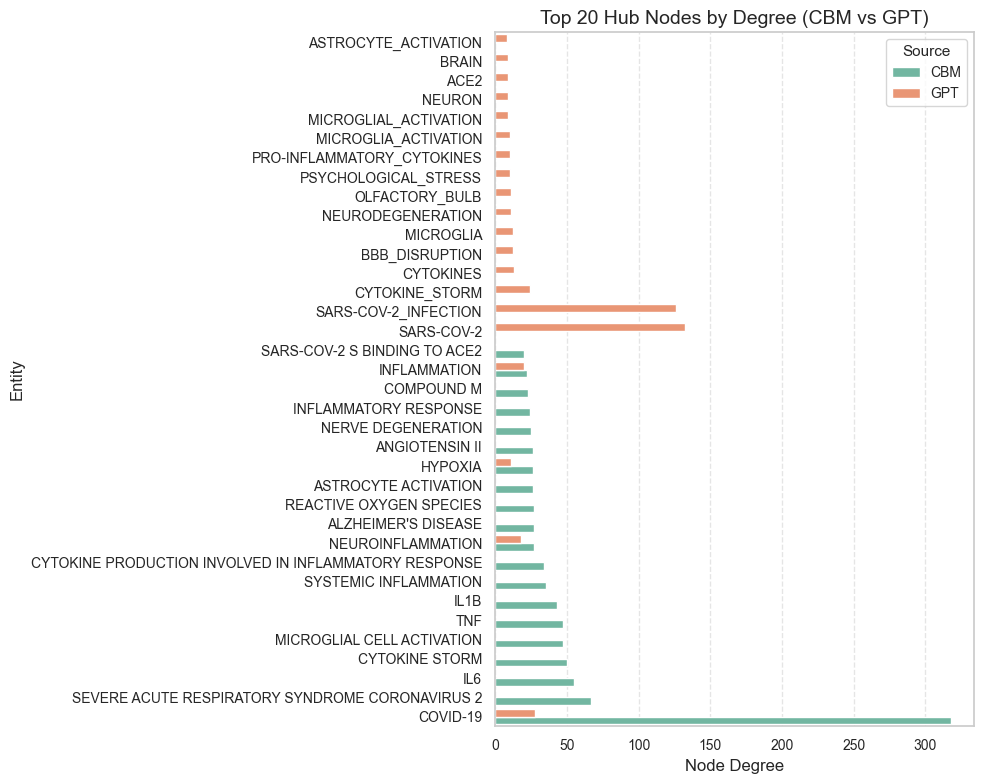

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка CSV-файлов
cbm_df = pd.read_csv("../neo4j_query_table_data_CBM.csv")
gpt_df = pd.read_csv("../neo4j_query_table_data_GPT.csv")

# Добавляем метку источника
cbm_df["source"] = "CBM"
gpt_df["source"] = "GPT"

# Отбираем топ-20 по каждому источнику
top_cbm = cbm_df.sort_values(by="degree", ascending=False).head(20)
top_gpt = gpt_df.sort_values(by="degree", ascending=False).head(20)

# Объединяем
top_combined = pd.concat([top_cbm, top_gpt], ignore_index=True)

# Настройка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Строим горизонтальный barplot
sns.barplot(
    data=top_combined,
    y="entity",
    x="degree",
    hue="source",
    palette="Set2",
    dodge=True
)

# Подписи и стиль
plt.title("Top 20 Hub Nodes by Degree (CBM vs GPT)", fontsize=14)
plt.xlabel("Node Degree", fontsize=12)
plt.ylabel("Entity", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Source", fontsize=10, title_fontsize=11)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Сохраняем в формате PNG и PDF
plt.savefig("../supplementary_hub_nodes.png", dpi=300)
plt.savefig("../supplementary_hub_nodes.tiff", dpi=300)

plt.show()


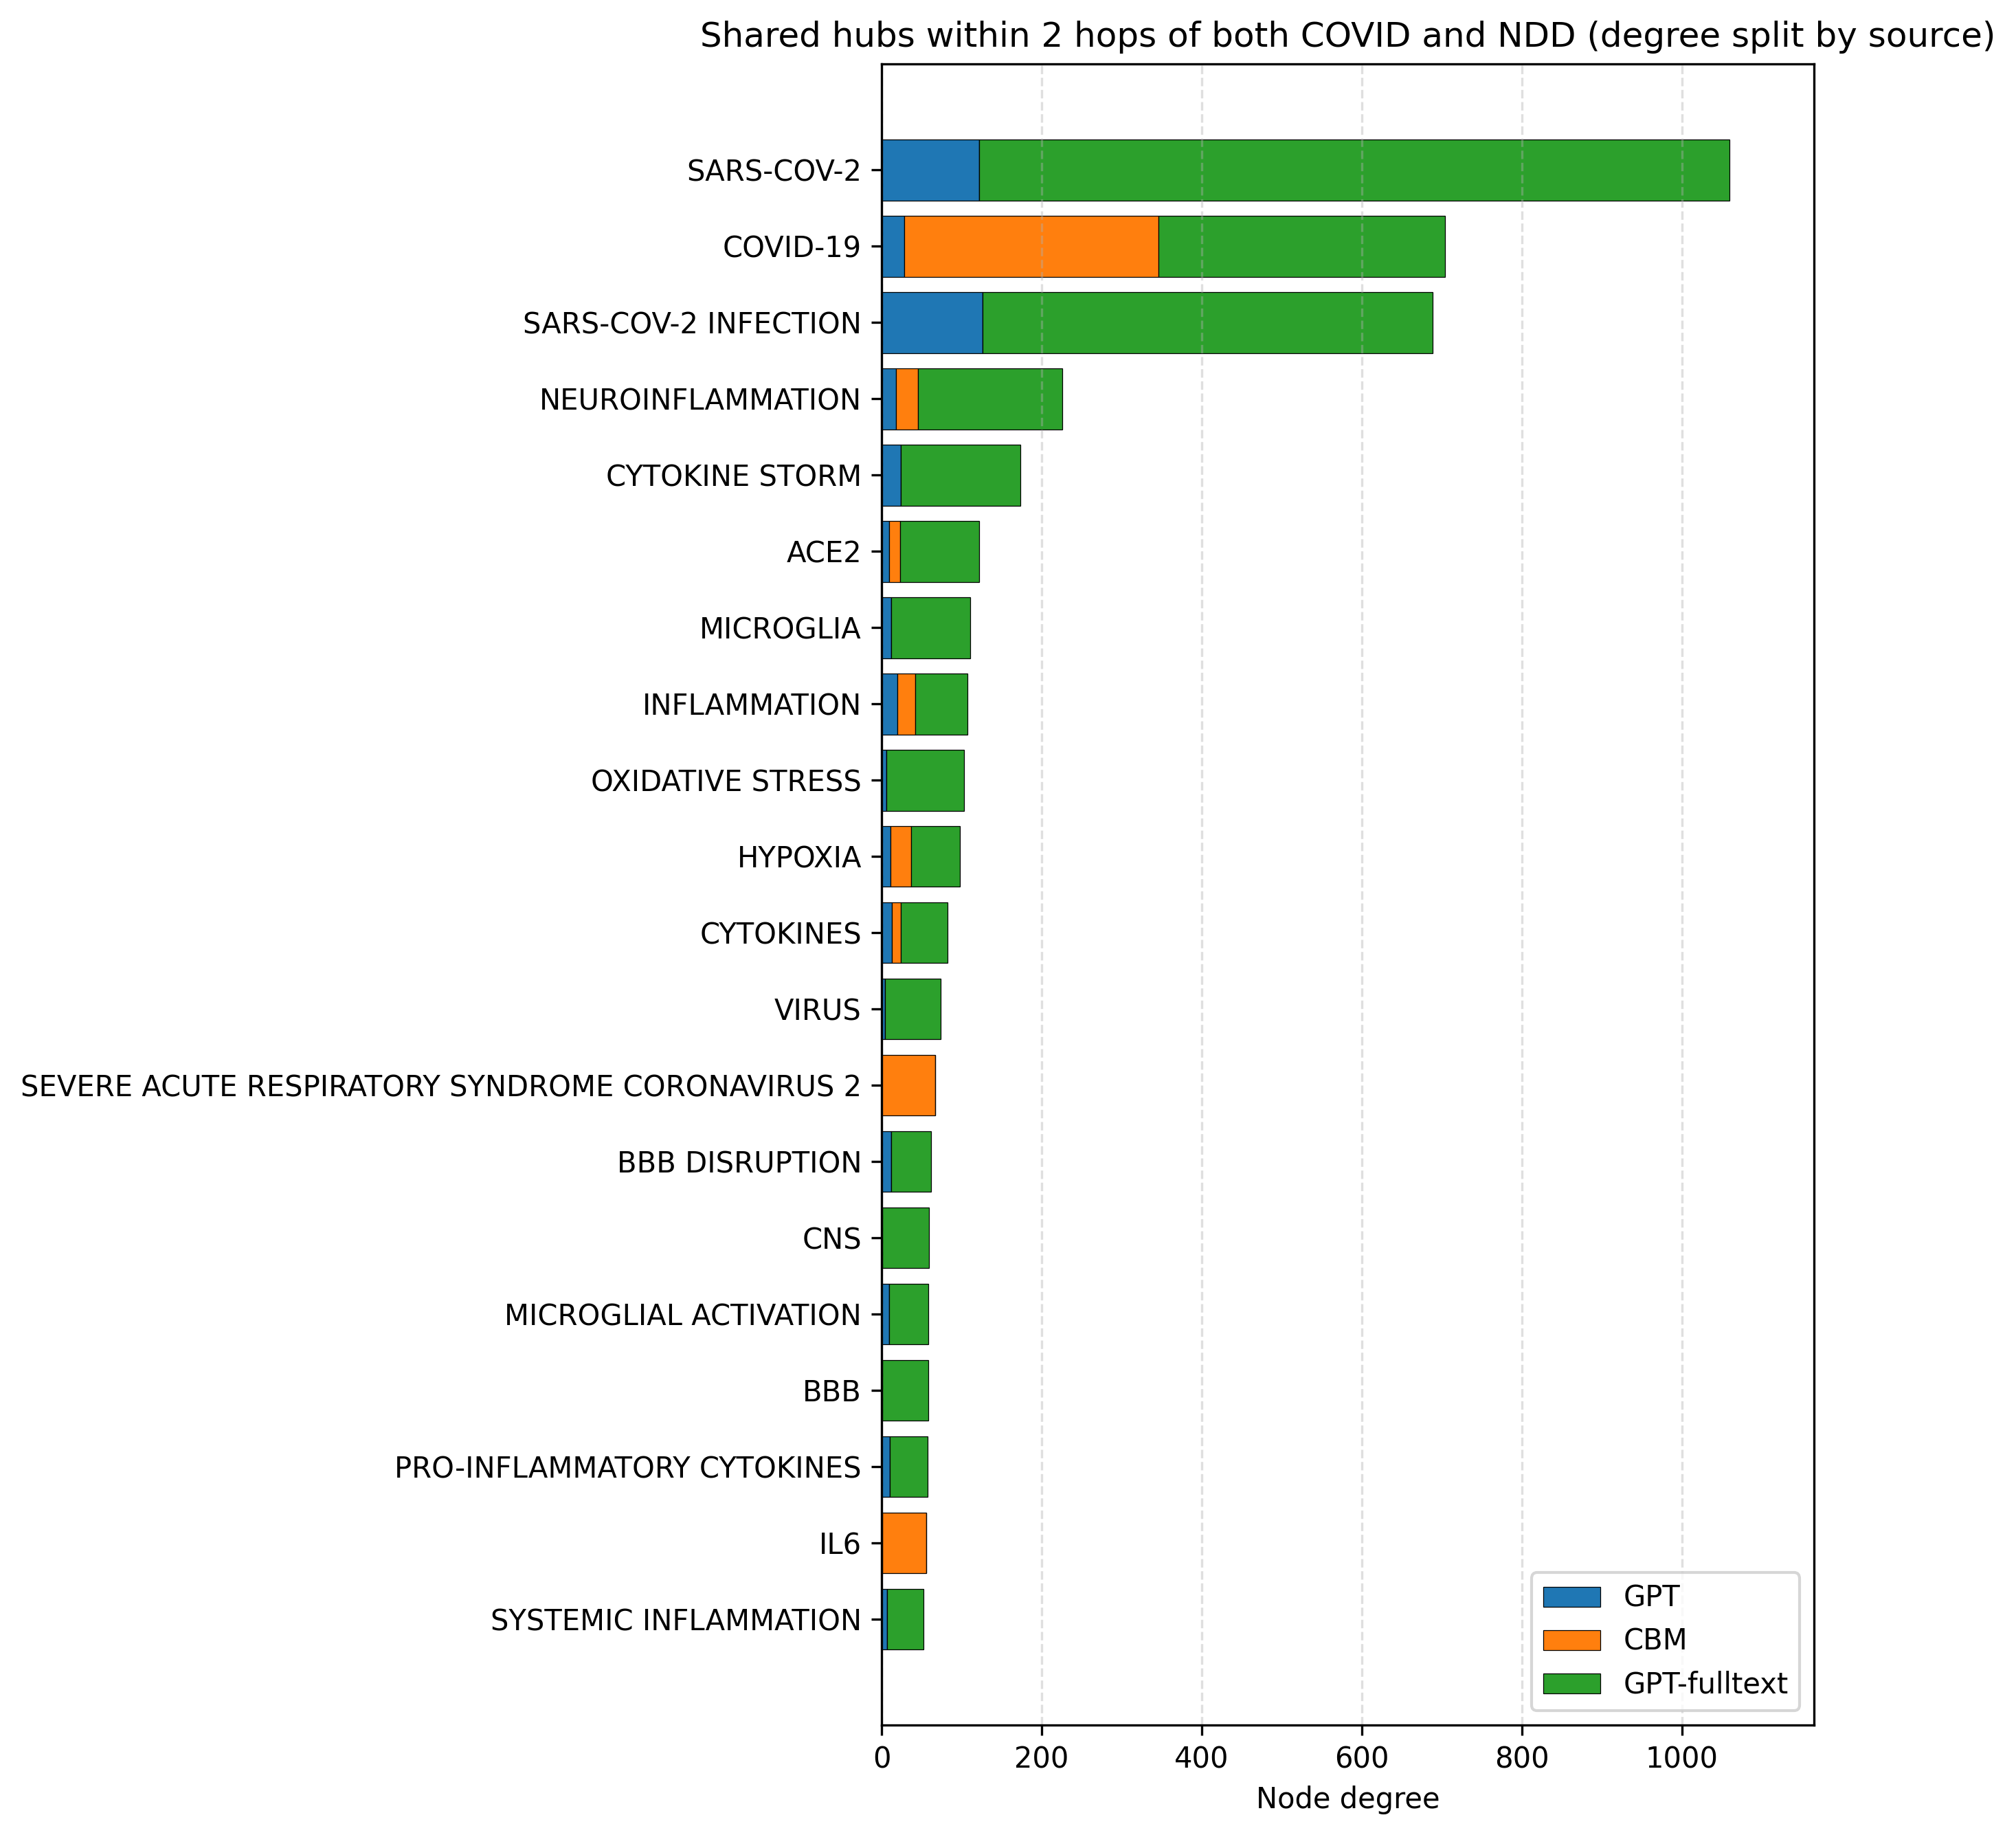

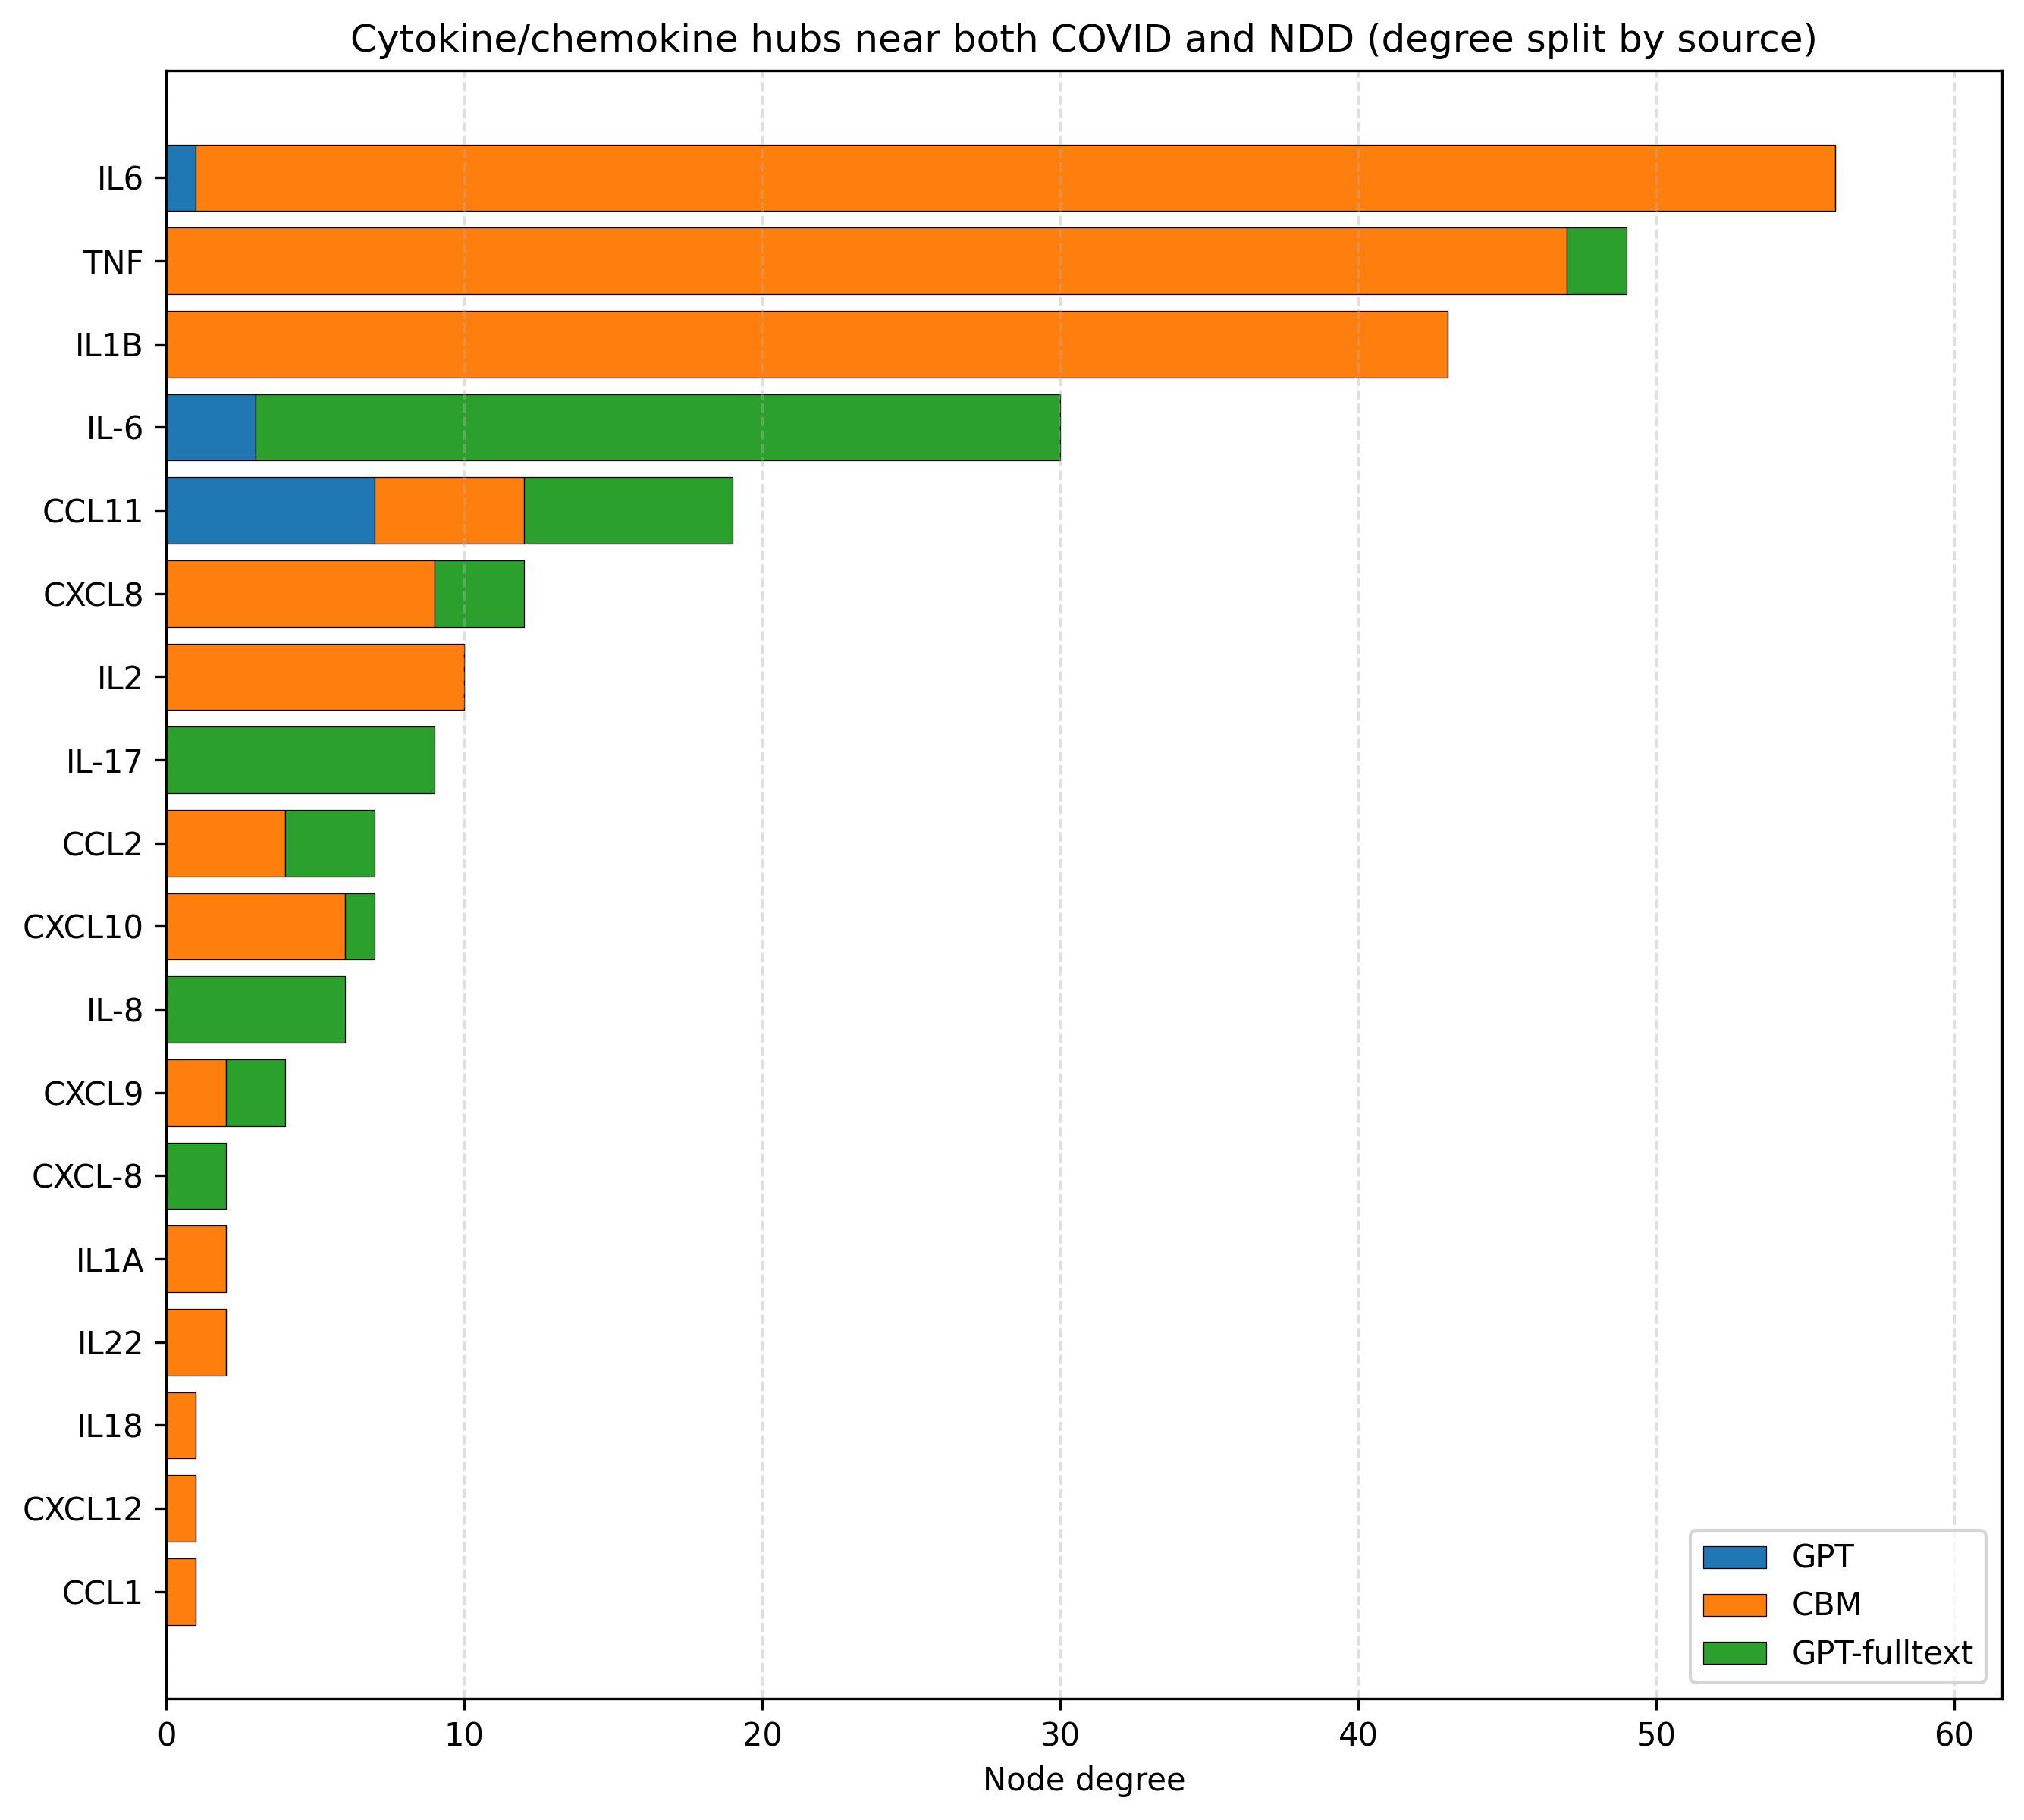

Saved:
 - ../data/bio_insides/outputs\Fig_Q1A_shared_hubs.png
 - ../data/bio_insides/outputs\Fig_Q1B_cytokine_hubs.png
 - ../data/bio_insides/outputs\Q1A_shared_hubs_topN.csv
 - ../data/bio_insides/outputs\Q1B_cytokine_hubs_topN.csv


In [ ]:
# --- Q1A/Q1B visualization: shared hubs & cytokine-focused hubs ---
# Requirements: pandas, matplotlib
# Inputs: CSVs exported from Neo4j Browser:
#   Q1A.csv with columns:  entity, labels, deg_total, deg_cbm, deg_gpt, deg_gpt_fulltext
#   Q1B.csv with columns:  cytokine (or entity), labels, deg_total, deg_cbm, deg_gpt, deg_gpt_fulltext
# Outputs:
#   ../data/bio_insides/outputs/Fig_Q1A_shared_hubs.png
#   ../data/bio_insides/outputs/Fig_Q1B_cytokine_hubs.png
#   ../data/bio_insides/outputs/Q1A_shared_hubs_topN.csv
#   ../data/bio_insides/outputs/Q1B_cytokine_hubs_topN.csv

import os
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
q1a_path = "../data/bio_insides/Q1A.csv"   # change if needed
q1b_path = "../data/bio_insides/Q1B.csv"   # change if needed
out_dir  = "../data/bio_insides/outputs"
top_n    = 20
dpi      = 300

os.makedirs(out_dir, exist_ok=True)

def _standardize_columns(df: pd.DataFrame, kind: str) -> pd.DataFrame:
    """
    Bring Q1A/Q1B result frames to a common schema:
      - name:              entity/cytokine string
      - deg_total:         total degree
      - deg_cbm:           degree from CBM edges
      - deg_gpt:           degree from GPT edges
      - deg_gpt_fulltext:  degree from GPT-fulltext edges
    """
    df = df.copy()

    # Detect the name column
    for cand in ("entity", "cytokine", "name", "x.name", "x"):
        if cand in df.columns:
            df.rename(columns={cand: "name"}, inplace=True)
            break
    else:
        raise ValueError(f"[{kind}] Cannot find a name/identifier column. Got: {df.columns.tolist()}")

    # Ensure numeric degree columns exist
    for col in ("deg_total", "deg_cbm", "deg_gpt", "deg_gpt_fulltext"):
        if col not in df.columns:
            df[col] = 0
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

    # Optional pretty label for plotting
    df["name_short"] = df["name"].astype(str).str.replace("_", " ")
    return df

def _make_hbar(df: pd.DataFrame, title: str, outfile: str):
    """
    Horizontal stacked bar chart of deg_total split into CBM / GPT / GPT-fulltext.
    Uses default matplotlib colors (no custom palette).
    """
    d = df.sort_values("deg_total", ascending=False).head(top_n).iloc[::-1]  # small->top for barh order

    plt.figure(figsize=(9, max(4, 0.45 * len(d))), dpi=dpi)

    # Stacks: GPT, CBM, GPT-fulltext (keep consistent order across plots)
    plt.barh(d["name_short"], d["deg_gpt"], label="GPT", edgecolor="black", linewidth=0.3)
    plt.barh(d["name_short"], d["deg_cbm"], left=d["deg_gpt"], label="CBM", edgecolor="black", linewidth=0.3)
    plt.barh(
        d["name_short"],
        d["deg_gpt_fulltext"],
        left=d["deg_gpt"] + d["deg_cbm"],
        label="GPT-fulltext",
        edgecolor="black",
        linewidth=0.3,
    )

    max_val = d["deg_total"].max()
    plt.xlim(0, max_val * 1.1)

    plt.xlabel("Node degree")
    plt.title(title)
    plt.legend()
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(outfile, dpi=dpi)
    plt.show()

    return d.iloc[::-1]  # return sorted descending for CSV

# ---------- Load & standardize ----------
q1a = pd.read_csv(q1a_path)
q1b = pd.read_csv(q1b_path)

q1a_std = _standardize_columns(q1a, "Q1A")
q1b_std = _standardize_columns(q1b, "Q1B")

# ---------- Plots ----------
top_q1a = _make_hbar(
    q1a_std,
    title="Shared hubs within 2 hops of both COVID and NDD (degree split by source)",
    outfile=os.path.join(out_dir, "Fig_shared_hubs.png"),
)

top_q1b = _make_hbar(
    q1b_std,
    title="Cytokine/chemokine hubs near both COVID and NDD (degree split by source)",
    outfile=os.path.join(out_dir, "Fig_cytokine_hubs.png"),
)

# ---------- Export top-N tables used in the figures ----------
top_q1a.to_csv(os.path.join(out_dir, "shared_hubs_topN.csv"), index=False)
top_q1b.to_csv(os.path.join(out_dir, "cytokine_hubs_topN.csv"), index=False)

print("Saved:",
      os.path.join(out_dir, "Fig_shared_hubs.png"),
      os.path.join(out_dir, "Fig_cytokine_hubs.png"),
      os.path.join(out_dir, "shared_hubs_topN.csv"),
      os.path.join(out_dir, "cytokine_hubs_topN.csv"),
      sep="\n - ")


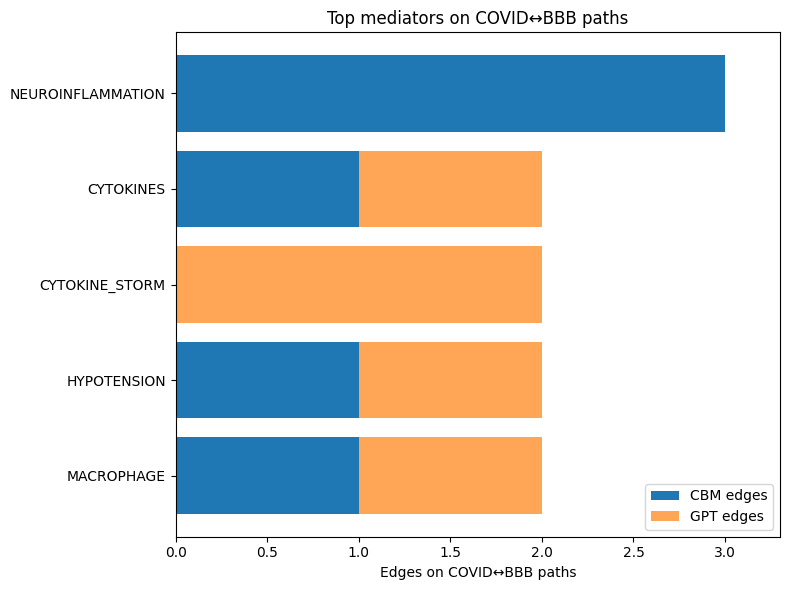

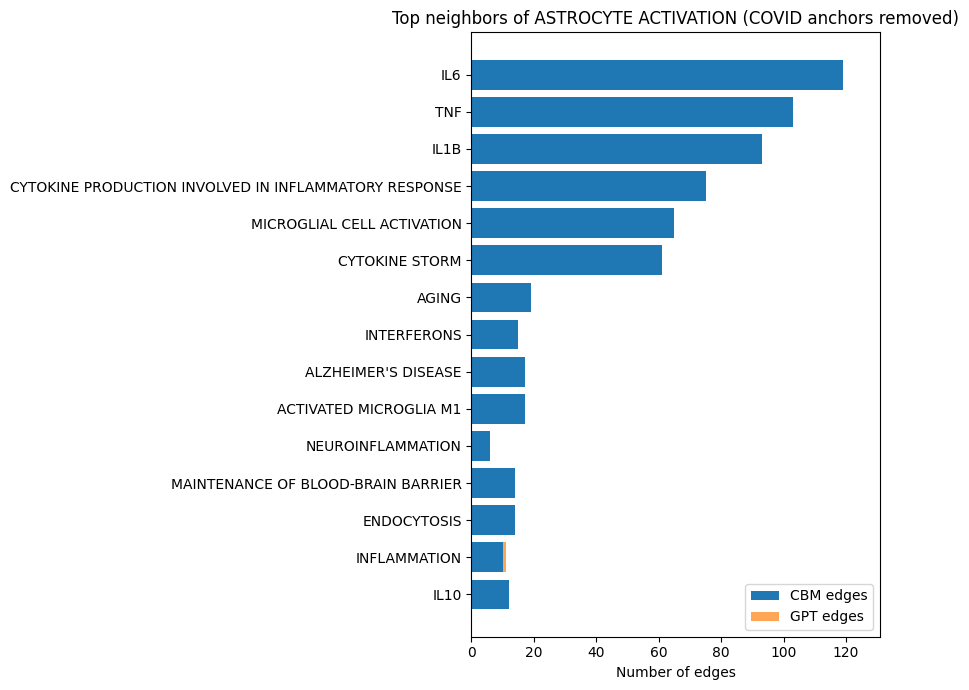

Figures saved in: ../data/bio_insides/outputs


In [15]:
# --- Plot COVID↔BBB mediators (A2_new) and Glia neighbors (B1) ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


# пути к CSV
A2_path = "../data/bio_insides/A2_new.csv"
B1_path = "../data/bio_insides/B1.csv"

out_dir = "../data/bio_insides/outputs"
os.makedirs(out_dir, exist_ok=True)

# ---------- A2_new: BBB mediators ----------
A2 = pd.read_csv(A2_path)
A2_sorted = A2.sort_values("edges_on_paths", ascending=False).head(10)

y = np.arange(len(A2_sorted))
plt.figure(figsize=(8, 6))
plt.barh(y, A2_sorted["cbm_edges_on_paths"], label="CBM edges")
plt.barh(y, A2_sorted["gpt_edges_on_paths"], left=A2_sorted["cbm_edges_on_paths"], 
         label="GPT edges", alpha=0.7)
plt.yticks(y, A2_sorted["mediator"])
plt.xlabel("Edges on COVID↔BBB paths")
plt.title("Top mediators on COVID↔BBB paths")
plt.legend()
plt.gca().invert_yaxis()
xmax = (A2_sorted["cbm_edges_on_paths"] + A2_sorted["gpt_edges_on_paths"]).max()
plt.xlim(0, xmax * 1.1)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "BBB_mediators_top10.png"), dpi=300)
plt.show()

# ---------- B1: Astrocyte activation neighbors ----------
B1 = pd.read_csv(B1_path)

# убираем COVID-19 и его варианты
covid_terms = {"covid-19","sars-cov-2","severe acute respiratory syndrome coronavirus 2"}
mask = ~B1["neighbor"].str.lower().isin(covid_terms)
B1 = B1[mask]

B1_ast = B1[B1["glia_anchor"] == "ASTROCYTE ACTIVATION"].copy()
B1_sorted = B1_ast.sort_values("deg_local", ascending=False).head(15)

y = np.arange(len(B1_sorted))
plt.figure(figsize=(9, 7))
plt.barh(y, B1_sorted["edges_cbm"], label="CBM edges")
plt.barh(y, B1_sorted["edges_gpt"], left=B1_sorted["edges_cbm"], 
         label="GPT edges", alpha=0.7)
plt.yticks(y, B1_sorted["neighbor"])
plt.xlabel("Number of edges")
plt.title("Top neighbors of ASTROCYTE ACTIVATION (COVID anchors removed)")
plt.legend()
plt.gca().invert_yaxis()
xmax = (B1_sorted["edges_cbm"] + B1_sorted["edges_gpt"]).max()
plt.xlim(0, xmax * 1.1)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "Astrocyte_neighbors_top15_noCOVID.png"), dpi=300)
plt.show()

print("Figures saved in:", out_dir)


In [16]:
pip install neo4j pandas networkx matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
# -*- coding: utf-8 -*-
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math, numpy as np
from pathlib import Path

# ---- Neo4j connection ----
NEO4J_URI  = "neo4j://127.0.0.1:7687"
NEO4J_USER = "neo4j"
NEO4J_PASS = "89204163228Ss"
DATABASE   = "neo4j"

# ---- parameters ----
DRUG = "MINOCYCLINE"
MINI_TARGETS = [
    "viral replication",
    "virus_replication",
    "microglial cell activation",
    "sars-cov2 crossing blood brain barrier",
    "impaired_neural-microglial_communication",
    "hypoxia-induced_neuroinflammation",
    "neuroinflammation",
    "neuronal_and_glial_injury",
]

BENEFICIAL_DOWN = [
    'DECREASE','INHIBIT','BLOCK','REDUCE',
    'ALLEVIATES','COUNTERACTS','PREVENTS','ATTENUATES'
]

ALIASES = {
    "VIRUS_REPLICATION": "Virus \nreplication",
    "VIRAL REPLICATION": "Viral \nreplication",
    "MICROGLIAL CELL ACTIVATION": "Microglial \nactivation",
    "SARS-COV2 CROSSING BLOOD BRAIN BARRIER": "SARS-CoV-2 \ncrossing BBB",
    "IMPAIRED_NEURAL-MICROGLIAL_COMMUNICATION": "Impaired neural– \nmicroglial \ncommunication",
    "HYPOXIA-INDUCED_NEUROINFLAMMATION": "Hypoxia-induced \nneuroinflammation",
    "NEUROINFLAMMATION": "Neuroinflammation",
    "NEURONAL_AND_GLIAL_INJURY": "Neuronal & \nglial injury",
    "MINOCYCLINE": "Minocycline"
}

# ---- helpers ----
def run(query, params=None):
    with driver.session(database=DATABASE) as s:
        return list(s.run(query, params or {}))

def fetch_edges(drug, sources):
    cypher = """
    MATCH (c:Chemical {name:$drug})-[r]->(m)
    WHERE any(t IN $mini_targets
              WHERE replace(toLower(m.name),'_',' ')
                    = replace(toLower(t),'_',' '))
      AND type(r) IN $beneficial_down
      AND r.source IN $sources
    RETURN c.name AS drug, m.name AS target, type(r) AS rel, r.source AS source
    """
    rows = run(cypher, {
        "drug": drug,
        "mini_targets": MINI_TARGETS,
        "beneficial_down": BENEFICIAL_DOWN,
        "sources": sources
    })
    return [(row["drug"], row["target"],
             {"source": row["source"], "rel": row["rel"]}) for row in rows]

def radial_positions(center, targets, radius=4.5, start_deg=90):
    """Spread targets evenly on a circle around the center."""
    pos = {center: (0,0)}
    n = max(1,len(targets))
    angles = np.linspace(0, 2*math.pi, n, endpoint=False) + math.radians(start_deg)
    for t, ang in zip(targets, angles):
        pos[t] = (radius*math.cos(ang), radius*math.sin(ang))
    return pos

def build_star_graph(drug, edges):
    """Create star-shaped DiGraph with drug as center."""
    G = nx.DiGraph()
    G.add_node(drug)
    targets = []
    for u,v,attr in edges:
        G.add_node(v)
        G.add_edge(u,v,**attr)
        targets.append(v)
    pos = radial_positions(drug, sorted(set(targets)))
    return G,pos

def prettify(name):
    return ALIASES.get(name, name.replace("_"," ").title())

def draw_graph(G,pos,title,outfile):
    SOURCE_STYLE = {
        "CBM": {"color":"#2F80ED", "style":"solid"},
        "GPT-fulltext": {"color":"#EB5757", "style":(0,(4,2))}
    }
    plt.figure(figsize=(8,9),dpi=300)
    # nodes
    node_sizes = [5000 if n==DRUG else 5000 for n in G.nodes()]
    nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color="#A0C4FF",   # light blue (можно поменять цвет)
    alpha=0.65,             # semi-transparent
    linewidths=0            # no border
    )
    # node labels
    labels = {n:prettify(n) for n in G.nodes()}
    nx.draw_networkx_labels(G,pos,labels=labels,font_size=10)

    # edges by source
    edges_all = list(G.edges(data=True))
    for src,style in SOURCE_STYLE.items():
        es = [(u,v,d) for (u,v,d) in edges_all if d.get("source")==src]
        if not es: continue
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u,v) for (u,v,_) in es],
            width=2.2,
            arrows=True,
            arrowstyle="-|>",
            arrowsize=14,
            edge_color=style["color"],
            style=style["style"],
            alpha=0.95,
            connectionstyle="arc3,rad=0",
            min_source_margin=40,   # отступ от центра исходного узла
            min_target_margin=54    # отступ от центра целевого узла
        )    
        # edge labels: show only relation
        e_labels = {(u,v): d.get("rel") for (u,v,d) in es}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=e_labels,
                                     font_size=9,rotate=False,
                                     bbox=dict(boxstyle="round,pad=0.2",fc="white",ec="none",alpha=0.85))

    # legend
    legend = [
        Line2D([0],[0],color="#2F80ED",lw=2.5,label="CBM"),
        Line2D([0],[0],color="#EB5757",lw=2.5,label="GPT-fulltext",linestyle=(0,(4,2)))
    ]
    plt.legend(handles=legend,loc="upper right",frameon=False,fontsize=10)

    plt.title(title,fontsize=13)
    plt.axis("off")
    Path("../data/bio_insides/outputs").mkdir(parents=True,exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"../data/bio_insides/outputs/{outfile}.tiff")
    plt.savefig(f"../data/bio_insides/outputs/{outfile}.png",dpi=300)
    plt.close()

# ---- main ----
driver = GraphDatabase.driver(NEO4J_URI,auth=(NEO4J_USER,NEO4J_PASS))
try:
    # CBM only
    cbm_edges = fetch_edges(DRUG,["CBM"])
    G_cbm,pos_cbm = build_star_graph(DRUG,cbm_edges)
    draw_graph(G_cbm,pos_cbm,
               title="Minocycline → beneficial edges • CBM",
               outfile="minocycline_cbm")

    # GPT-fulltext only
    gptft_edges = fetch_edges(DRUG,["GPT-fulltext"])
    G_gptft,pos_gptft = build_star_graph(DRUG,gptft_edges)
    draw_graph(G_gptft,pos_gptft,
               title="Minocycline → beneficial edges • GPT-fulltext",
               outfile="minocycline_gptfulltext")

    # Combined
    both_edges = cbm_edges+gptft_edges
    G_both,pos_both = build_star_graph(DRUG,both_edges)
    draw_graph(G_both,pos_both,
               title="Minocycline → beneficial edges • CBM + GPT-fulltext",
               outfile="minocycline_combined")
finally:
    driver.close()



C:\Users\User\AppData\Local\Temp\ipykernel_26544\3475907450.py:143: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


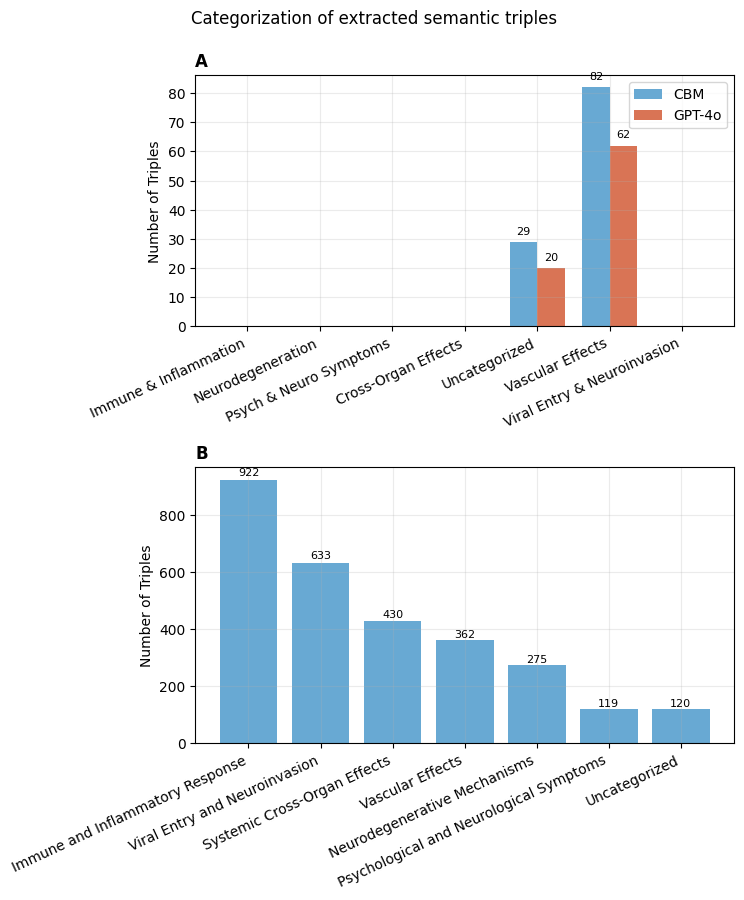

In [2]:
# Fig. 3 — Triple categorization (A,B)
# Requirements: pandas, matplotlib
# Files expected in the same folder (adjust paths if needed):
#   - Triples_CBM_Gold_Standard_SubjObj_Categorized.csv
#   - Triples_GPT_for_comparison_SubjObj_Categorized.csv
#   - Triples_Final_All_Relevant_Categorized_GPT4o.csv

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- paths ----------
cbm_path   = "../data/gold_standard_comparison/Triples_CBM_Gold_Standard_SubjObj_Categorized.csv"
gpt_eval_path = "../data/gold_standard_comparison/Triples_GPT_for_comparison_SubjObj_Categorized.csv"
gpt_full_path = "../data/triples_output/Triples_Final_All_Relevant_Categorized_GPT4o.csv"

# Robust Fig. 3 plotter — handles CSVs with , ; \t, quoted commas, BOM, or Excel files
# Files expected (adjust paths if needed):
#   Triples_CBM_Gold_Standard_SubjObj_Categorized.csv
#   Triples_GPT_for_comparison_SubjObj_Categorized.csv
#   Triples_Final_All_Relevant_Categorized_GPT4o.csv

# ---------- robust loader ----------
def read_table(path):
    path = Path(path)
    # 1) Excel?
    if path.suffix.lower() in {".xlsx", ".xls"}:
        return pd.read_excel(path)

    # 2) Try CSV with automatic delimiter sniffing (engine='python' can infer)
    try:
        return pd.read_csv(path, sep=None, engine="python", encoding="utf-8-sig")
    except Exception:
        # 3) Try common delimiters explicitly
        for sep in [",", ";", "\t", "|"]:
            try:
                return pd.read_csv(path, sep=sep, engine="python", encoding="utf-8-sig")
            except Exception:
                continue
        # 4) Last resort: read as Excel (some .csv are actually Excel)
        try:
            return pd.read_excel(path)
        except Exception as e:
            raise RuntimeError(f"Could not read file: {path}") from e

def get_category_series(df):
    # Normalize column names
    cols = {c.strip().lower(): c for c in df.columns}
    # Find a column that looks like 'category'
    candidate = None
    for key in ["category", "categories", "Category", "Category "]:
        if key.lower() in cols:
            candidate = cols[key.lower()]
            break
    if candidate is None:
        # try to guess by exact match ignoring case/space
        for c in df.columns:
            if c.strip().lower() == "category":
                candidate = c
                break
    if candidate is None:
        raise KeyError(f"'Category' column not found. Columns: {list(df.columns)}")
    return df[candidate].astype(str).str.strip()

def load_counts(path):
    df = read_table(path)
    s = get_category_series(df)
    return s.value_counts()

# ---------- load ----------
cbm_counts      = load_counts(cbm_path)
gpt_eval_counts = load_counts(gpt_eval_path)
gpt_full_counts = load_counts(gpt_full_path)

# ---------- category order (panel A fixed to match screenshot) ----------
cats_A = [
    "Immune & Inflammation",
    "Neurodegeneration",
    "Psych & Neuro Symptoms",
    "Cross-Organ Effects",
    "Uncategorized",
    "Vascular Effects",
    "Viral Entry & Neuroinvasion",
]

def align_counts(counts, categories):
    return [int(counts.get(c, 0)) for c in categories]

cbm_A = align_counts(cbm_counts, cats_A)
gpt_A = align_counts(gpt_eval_counts, cats_A)

# ---------- panel B order (desc, with 'Uncategorized' forced last) ----------
b_sorted = gpt_full_counts.sort_values(ascending=False)
if "Uncategorized" in b_sorted.index:
    unc = int(b_sorted.loc["Uncategorized"])
    b_sorted = b_sorted.drop("Uncategorized")
    b_sorted = pd.concat([b_sorted, pd.Series({"Uncategorized": unc})])
cats_B = list(b_sorted.index)
vals_B = [int(b_sorted[c]) for c in cats_B]

# ---------- plotting ----------
plt.rcParams.update({
    "figure.figsize": (7.5, 9.0),
    "font.size": 10,
    "axes.grid": True,
    "grid.alpha": 0.25
})
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1, 1.1])

# Panel A
axA = fig.add_subplot(gs[0, 0])
x = range(len(cats_A))
width = 0.38
bars1 = axA.bar([i - width/2 for i in x], cbm_A, width=width, label="CBM", color="#68a9d3")
bars2 = axA.bar([i + width/2 for i in x], gpt_A, width=width, label="GPT-4o", color="#d97455")
axA.set_xticks(list(x))
axA.set_xticklabels(cats_A, rotation=25, ha="right")
axA.set_ylabel("Number of Triples")
axA.set_title("A", loc="left", fontweight="bold")
axA.legend()
for b in list(bars1) + list(bars2):
    h = b.get_height()
    if h > 0:
        axA.text(b.get_x() + b.get_width()/2, h + max(2, 0.01*h), f"{int(h)}",
                 ha="center", va="bottom", fontsize=8)

# Panel B
axB = fig.add_subplot(gs[1, 0])
xB = range(len(cats_B))
barsB = axB.bar(xB, vals_B, color="#68a9d3")
axB.set_xticks(list(xB))
axB.set_xticklabels(cats_B, rotation=25, ha="right")
axB.set_ylabel("Number of Triples")
axB.set_title("B", loc="left", fontweight="bold")
for b in barsB:
    h = b.get_height()
    if h > 0:
        axB.text(b.get_x() + b.get_width()/2, h + max(3, 0.01*h), f"{int(h)}",
                 ha="center", va="bottom", fontsize=8)

fig.suptitle("Categorization of extracted semantic triples", y=0.995, fontsize=12)
plt.tight_layout()
plt.show()
# To save:
# fig.savefig("Fig3_Triple_Categorization.png", dpi=300, bbox_inches="tight")
